In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
# Globals
ORANGE = '#F2BE4A'
RED = '#ef4123'
GRAY = '#545453'

## Random Forest

## Classification

### Prepare Dataset

In [3]:
data = pd.read_csv('./data/penguins_size.csv')

data = data.dropna()
data = data.drop(['sex', 'island', 'flipper_length_mm', 'body_mass_g'], axis=1)
data = data[data['species'] != 'Chinstrap']

X = data.drop(['species'], axis=1).values

y = data['species']
species = {'Adelie': 1, 'Gentoo': 2}
y = [species[item] for item in y]
y = np.array(y) 

# Remove sample that is too close
X = np.delete(X, 182, axis=0)
y = np.delete(y, 182, axis=0)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

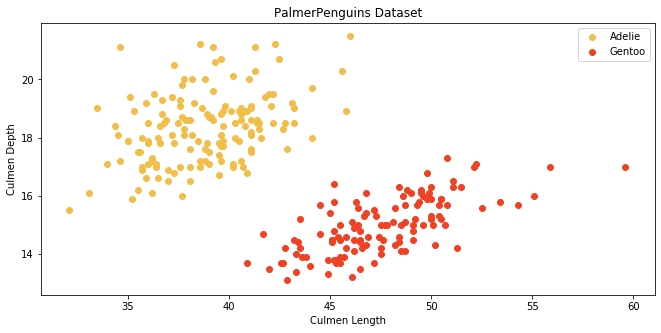

In [5]:
plt.figure(figsize=(11, 5))

plt.title("PalmerPenguins Dataset")
plt.xlabel('Culmen Length')
plt.ylabel('Culmen Depth')

plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color=ORANGE, label='Adelie')
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], color=RED, label='Gentoo')

plt.legend();

### Python Implementation

In [6]:
class MyGiniCalculator():
   
    def _single_class_gini(self, class_count, total_instances_count):
        return -(class_count/total_instances_count)
    
    def _group_gini(self, class1_count, class2_count):
        if class1_count == 0 or class2_count == 0:
            return 0
        
        total_count = class1_count + class2_count
        return self._single_class_gini(class1_count, total_count) + self._single_class_gini(class2_count, total_count)
    
    def _leaf_gini(self, data):
        gini = 0
        
        num_istances = len(data)
        classes = set(data)
        
        for classs in classes:
            class_count = sum(data == classs)
            gini += class_count * 1.0/num_istances * self._group_gini(sum(data == classs), sum(data != classs))
        
        return gini, num_istances
    
    def get_gini(self, is_left, y):
        if len(is_left) != len(y):
            print('Wrong length')
            return None
        
        num_istances = len(y)
        left_gini, left_count = self._leaf_gini(y[is_left])
        right_gini, right_count = self._leaf_gini(y[~is_left])

        total_gini = left_count*1.0/num_istances * left_gini + right_count*1.0/num_istances * right_gini 
        
        return total_gini
    
class MyDecissionTreeClassifier():
    def __init__(self, feature_names, max_depth = 5):
        self.gini_calculator = MyGiniCalculator()
        self.feature_names = feature_names
        self.max_depth = max_depth
        self.depth = 0
    
    def _get_best_feature_split(self, feature, y):
        min_gini = 10
        
        for value in set(feature):
            is_left = feature < value
            gini = self.gini_calculator.get_gini(is_left, y)
            if gini < min_gini:
                min_gini = gini
            cutoff = value
            
        return min_gini, cutoff
    
    def _get_best_split(self, X, y):
        feature = None
        min_gini = 1
        cutoff = None
        
        for i, c in enumerate(X.T):
            gini, cur_cutoff = self._get_best_feature_split(c, y)
            
            if gini == 0: 
                return i, cur_cutoff, gini
            elif gini <= min_gini:
                min_gini = gini
                feature = i
                cutoff = cur_cutoff
                
        return feature, cutoff, min_gini
    
    def _get_prediction(self, row):
        cur_layer = self.trees
        
        while cur_layer:
            prev_layer = cur_layer

            if row[cur_layer['index']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']          
        else:
            return prev_layer.get('value')
    
    def fit(self, X, y, parent_leaf={}, depth=0):
        
        if parent_leaf is None or len(y) == 0 or depth >= self.max_depth: 
            return None

        feature, cutoff, gini = self._get_best_split(X, y)
        y_left = y[X[:, feature] < cutoff]
        y_right = y[X[:, feature] >= cutoff]
        
        parent_leaf = {
            'feature': self.feature_names[feature], 
            'index': feature,
            'cutoff': cutoff,
            'value': np.round(np.mean(y))}
        
        
        parent_leaf['left'] = self.fit(X[X[:, feature] < cutoff], y_left, {}, depth+1)
        parent_leaf['right'] = self.fit(X[X[:, feature] >= cutoff], y_right, {}, depth+1)
        
        self.depth += 1 
        self.trees = parent_leaf
        
        return parent_leaf   
    
    def predict(self, X):
        results = np.array([0]*len(X))
        
        for i, row in enumerate(X):
            results[i] = self._get_prediction(row)
            
        return results

In [7]:
class MyRandomForest():
    def __init__(self, num_trees, feature_names, max_features, max_depth=5):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.max_features = max_features
        
        self.trees = []
        for _ in range(num_trees):
            self.trees.append(MyDecissionTreeClassifier(feature_names, self.max_depth))
                
    def get_random_subsets(self, X, y, num_subsets):
        num_samples = np.shape(X)[0]

        X_y = np.concatenate((X, y.reshape((1, len(y))).T), axis=1)
        np.random.shuffle(X_y)

        subsets = []
        subsample_size = int(num_samples // 2)

        for _ in range(num_subsets):
            index = np.random.choice(
                range(num_samples),
                size=np.shape(range(subsample_size)),
                replace=True)

            X = X_y[index][:, :-1]
            y = X_y[index][:, -1]

            subsets.append([X, y])

        return subsets        
        
    def fit(self, X, y):
        num_features = np.shape(X)[1]
        subsets = self.get_random_subsets(X, y, self.num_trees)

        for i in range(self.num_trees):
            X_subset, y_subset = subsets[i]
                
            # Feature bagging
            idx = np.random.choice(range(num_features), size=self.max_features, replace=True)
            self.trees[i].feature_indices = idx
            X_subset = X_subset[:, idx]
            self.trees[i].fit(X_subset, y_subset)
         
    
    def predict(self, X):
        y_preds = np.empty((X.shape[0], len(self.trees)))
                
        for i, tree in enumerate(self.trees):
            idx = tree.feature_indices
            prediction = tree.predict(X[:, idx])
            y_preds[:, i] = prediction
            
        y_pred = []
        for sample_predictions in y_preds:
            y_pred.append(np.bincount(sample_predictions.astype('int')).argmax())
                
        return y_pred

In [8]:
model = MyRandomForest(feature_names=data.drop(['species'], axis=1).columns, num_trees=11, max_features=2)
tree = model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.62      1.00      0.77        28
           2       1.00      0.32      0.48        25

    accuracy                           0.68        53
   macro avg       0.81      0.66      0.63        53
weighted avg       0.80      0.68      0.63        53



### Using SciKit Learn

In [9]:
rf_classifier = RandomForestClassifier(n_estimators=11, max_leaf_nodes=16, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

rf_predictions = rf_classifier.predict(X_test)
print(metrics.classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        25

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53



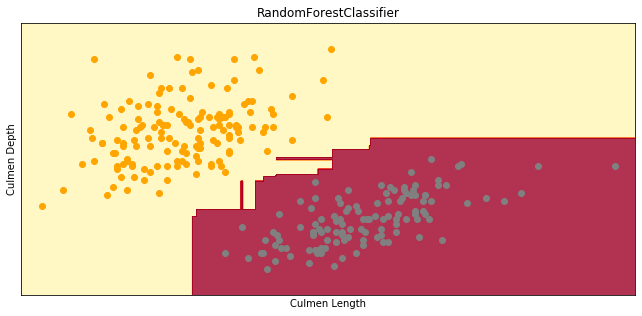

In [10]:
h = .02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(11, 5))

plt.subplot(1, 1, 1)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Z = rf_classifier.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='YlOrRd', alpha=0.8)

plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='orange', label='Adelie')
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], color='gray', label='Gentoo')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.title('RandomForestClassifier')
plt.xlabel('Culmen Length')
plt.ylabel('Culmen Depth')

plt.show()

## Regression

In [11]:
def print_evaluation_metrics(actual_values, predictions):
    print (f'MAE: {metrics.mean_absolute_error(actual_values, predictions)}')
    print (f'MSE: {metrics.mean_squared_error(actual_values, predictions)}')
    print(f'RMSE: {sqrt(metrics.mean_squared_error(actual_values, predictions))}')
    print (f'R Squared: {metrics.r2_score(actual_values, predictions)}')

### Prepare the data

In [12]:
data = pd.read_csv('./data/boston_housing.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


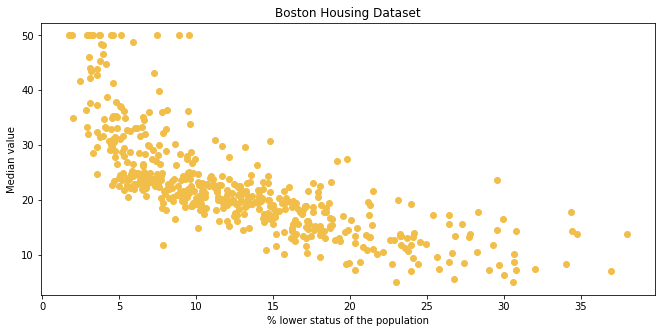

In [13]:
data = data.dropna()

X = data['lstat'].values
X = X.reshape(-1, 1)

y = data['medv'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

plt.figure(figsize=(11, 5))

plt.title("Boston Housing Dataset")
plt.xlabel('% lower status of the population')
plt.ylabel('Median value')

plt.scatter(x = X, y = y, color=ORANGE)
plt.show()

### Using Sci-Kit Learn

In [14]:
rfr_model = RandomForestRegressor(n_estimators=111, max_leaf_nodes=16,)
rfr_model.fit(X_train, y_train)

rfr_predictions = rfr_model.predict(X_test)

print_evaluation_metrics(y_test, rfr_predictions)

pd.DataFrame({
    'Actual Value': y_test,
    'RandomForestRegressor Prediction': rfr_predictions,
})

MAE: 3.7711599513447256
MSE: 24.157626367620978
RMSE: 4.915040830717582
R Squared: 0.6627653295633458


,Actual Value,RandomForestRegressor Prediction
0,20.5,16.165145
1,5.6,12.318675
2,13.4,12.640325
3,12.6,16.561760
4,21.2,30.539810
...,...,...
97,25.0,22.725723
98,19.5,16.081323
99,19.9,16.561760
100,15.4,13.021295


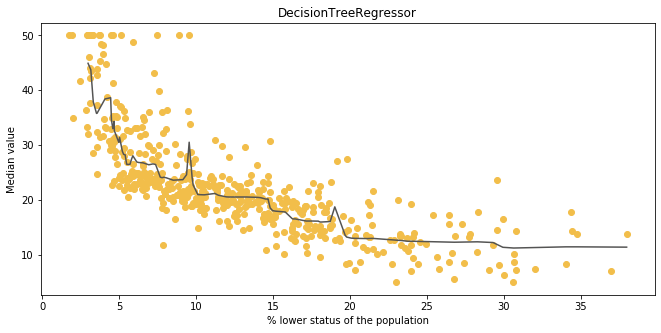

In [15]:
plt.figure(figsize=(11, 5))

plt.title("DecisionTreeRegressor")
plt.xlabel('% lower status of the population')
plt.ylabel('Median value')

plt.scatter(x = X, y = y, color=ORANGE)
values = np.column_stack((X_test, rfr_predictions))
values = values[values[:,0].argsort()]
plt.plot(values[:,0], values[:,1], color=GRAY)
plt.show()